In [15]:
dpi = 300
image_save_dpi = 300

import matplotlib_inline

%matplotlib inline
%matplotlib inline

import matplotlib.pyplot as plt

matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
%config InlineBackend.figure_formats = ['retina'] 

import seaborn as sns
import matplotlib

sns.set(rc={"figure.dpi":dpi, 'savefig.dpi':dpi})
sns.set_context('notebook')
sns.set_style("ticks")
matplotlib.rcParams["figure.dpi"] = dpi
plt.rcParams['figure.dpi'] = dpi

In [16]:
import numpy as np
import pandas as pd

# Data

In [17]:
data = pd.read_excel('Data/Data_Volcano_Eruption.xlsx',skiprows=[0])
list1 = data[['Volcano Name', 'VEI', 'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day']]
list1 = list1[
    (list1['Start Year']>=1800)]

## Data filtering

In [18]:
# Assuming list1 is already defined and contains the 'Start Year' data
list1 = list1['Start Year'].value_counts()

# Sort the index
list1 = list1.sort_index()

# Convert to DataFrame
list1 = list1.reset_index()

# Rename the columns
list1.columns = ['Year', 'Count']

# Now list1 has columns named 'Year' and 'Count'
list1 = list1.sort_values(by='Year', ascending=False)
list1 = list1[list1['Count'] >2]
list1

,Year,Count
188,2020,3
183,2014,5
182,2013,6
179,2010,3
178,2009,3
...,...,...
19,1825,5
17,1822,3
14,1818,4
13,1817,3


## Data processing

In [19]:
list2 = list1
list2['Repose'] = list1['Year'].diff(periods=-1)
list2 = list2.dropna(subset='Repose')
list2

,Year,Count,Repose
188,2020,3,6.0
183,2014,5,1.0
182,2013,6,3.0
179,2010,3,1.0
178,2009,3,10.0
...,...,...,...
20,1826,4,1.0
19,1825,5,3.0
17,1822,3,4.0
14,1818,4,1.0


## stationarity check

ADF Statistic: -7.049766253010579
p-value: 5.565539417804964e-10
Critical values:
   1%, -3.520713130074074
Critical values:
   5%, -2.9009249540740742
Critical values:
   10%, -2.5877813777777776
Reject Ho - Time Series is Stationary


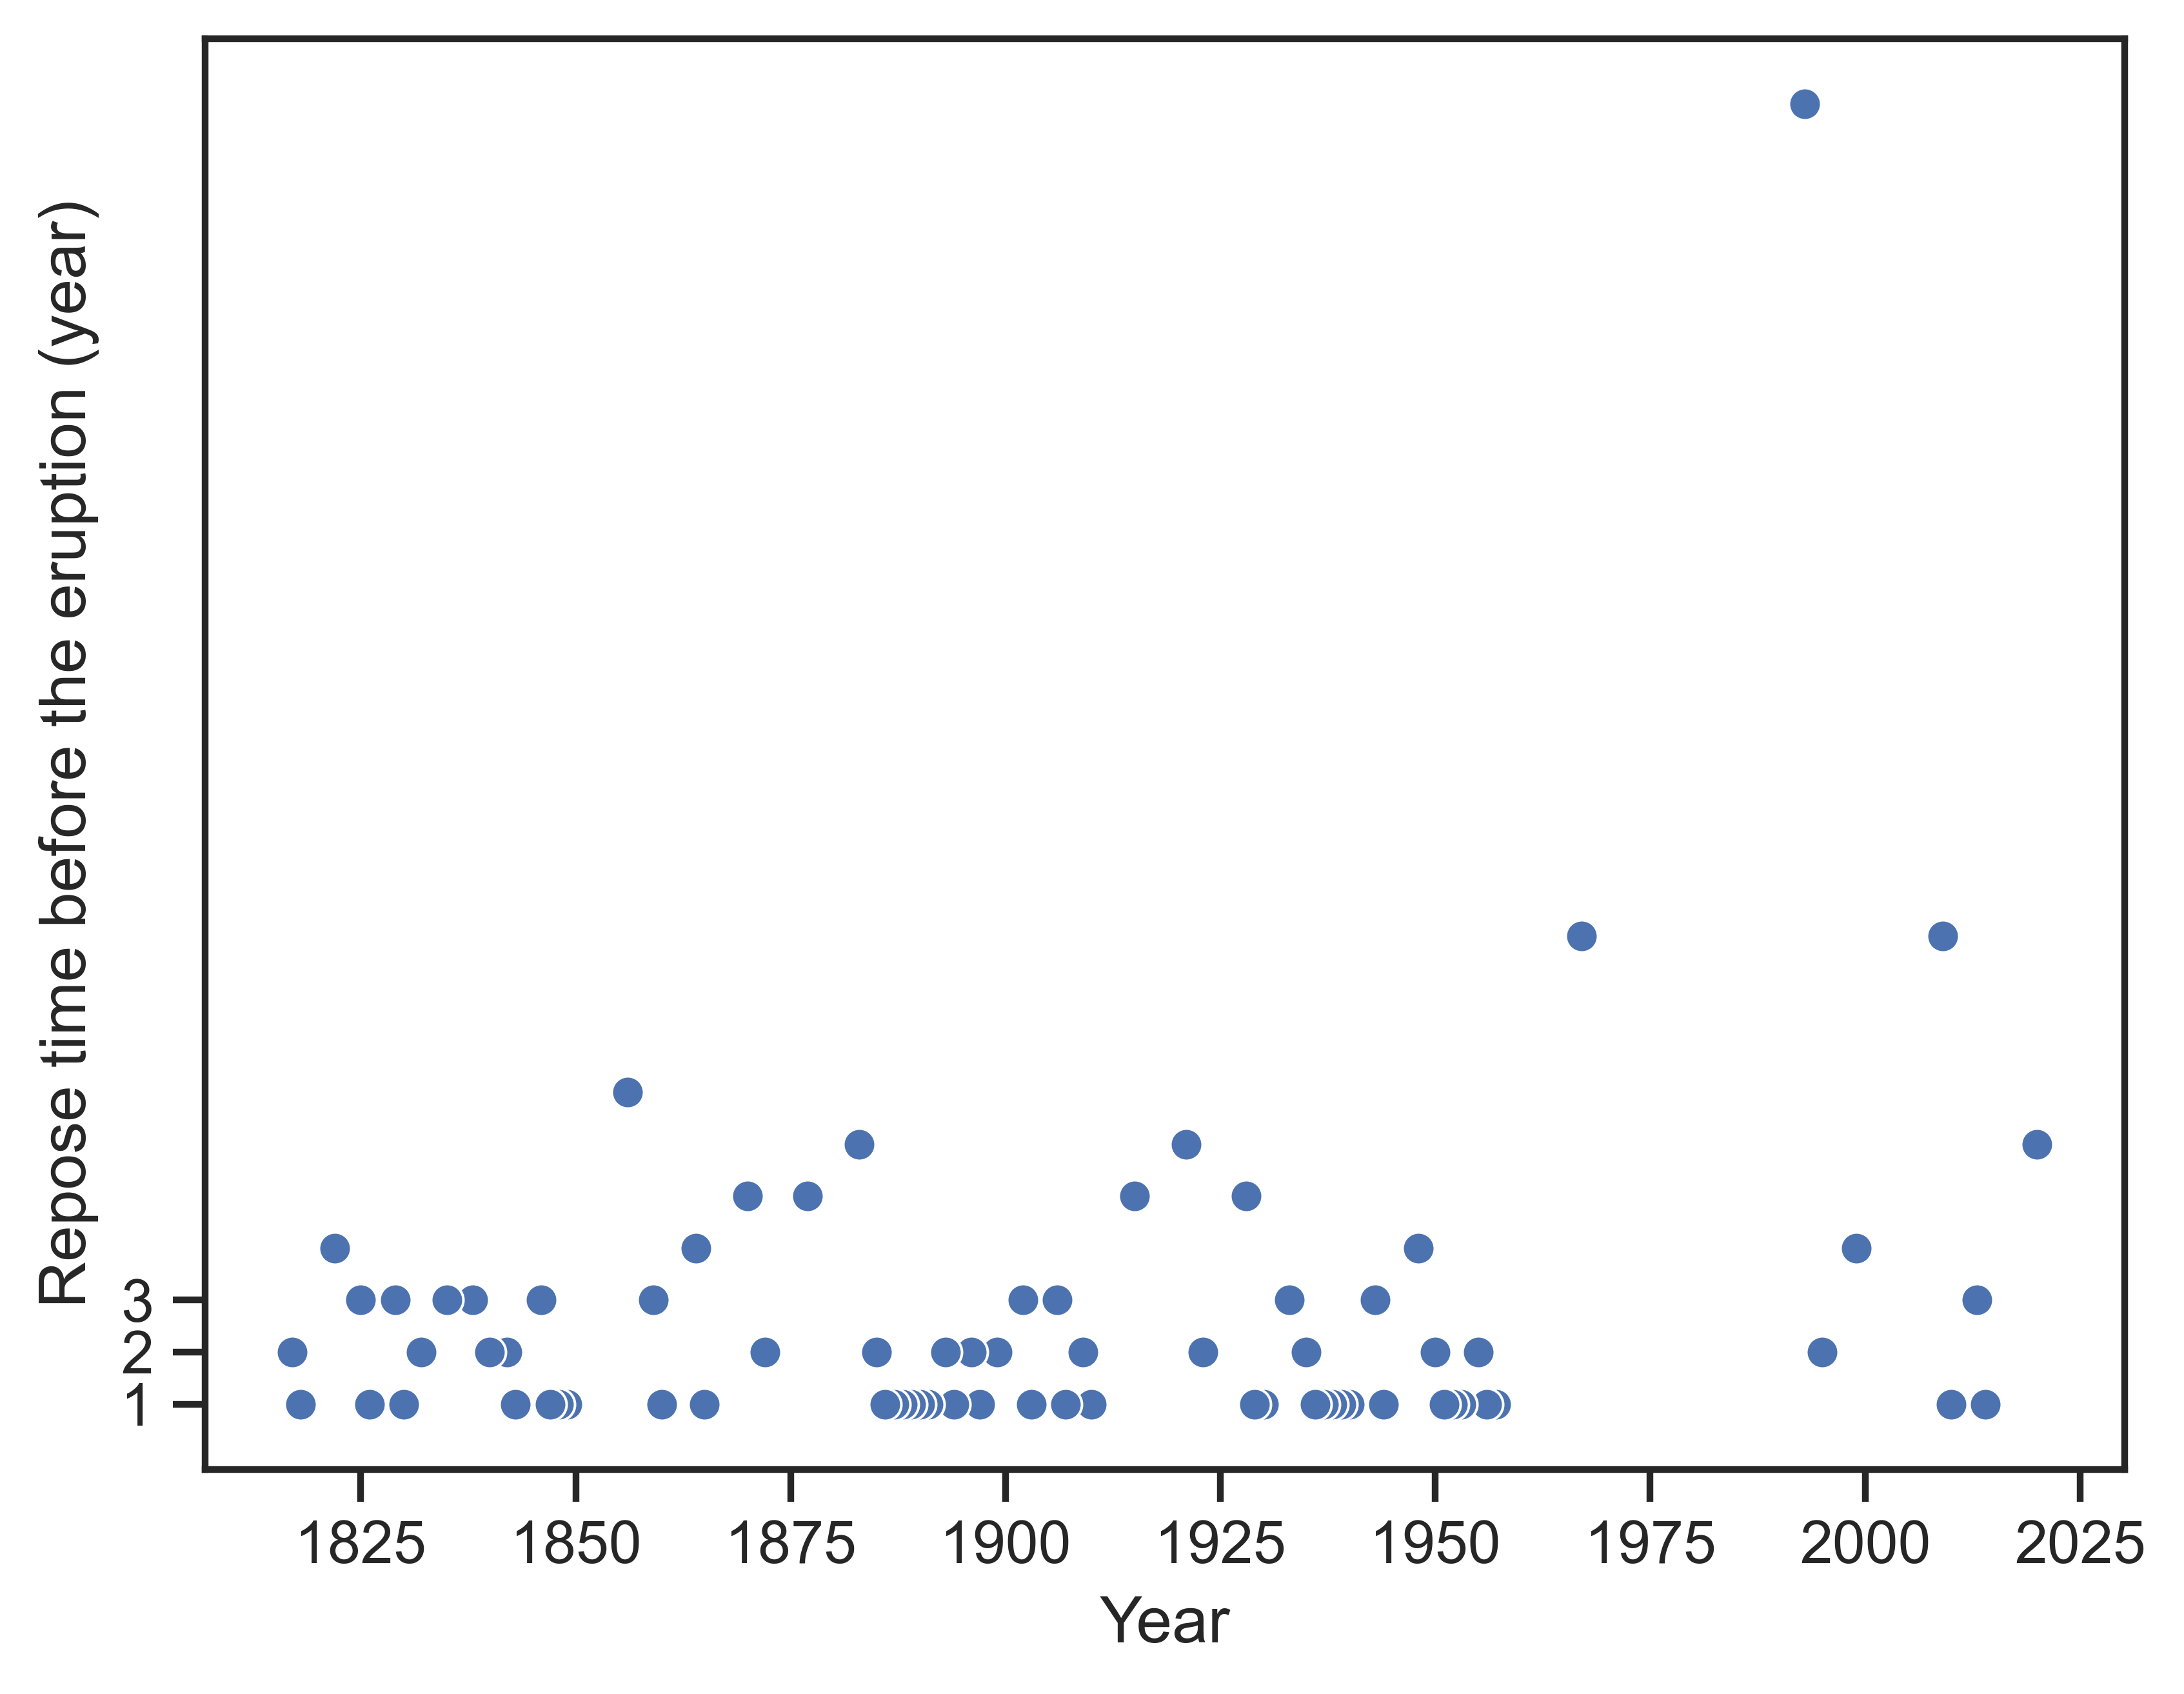

In [20]:
import seaborn as sns
sns.scatterplot(data=list2, x='Year', y='Repose')
plt.yticks(np.arange(1,4,1))
plt.ylabel('Repose time before the eruption (year)')

from statsmodels.tsa.stattools import adfuller, kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
result = adfuller(list2['Repose'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical values:')
    print(f'   {key}, {value}')
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

## independence check

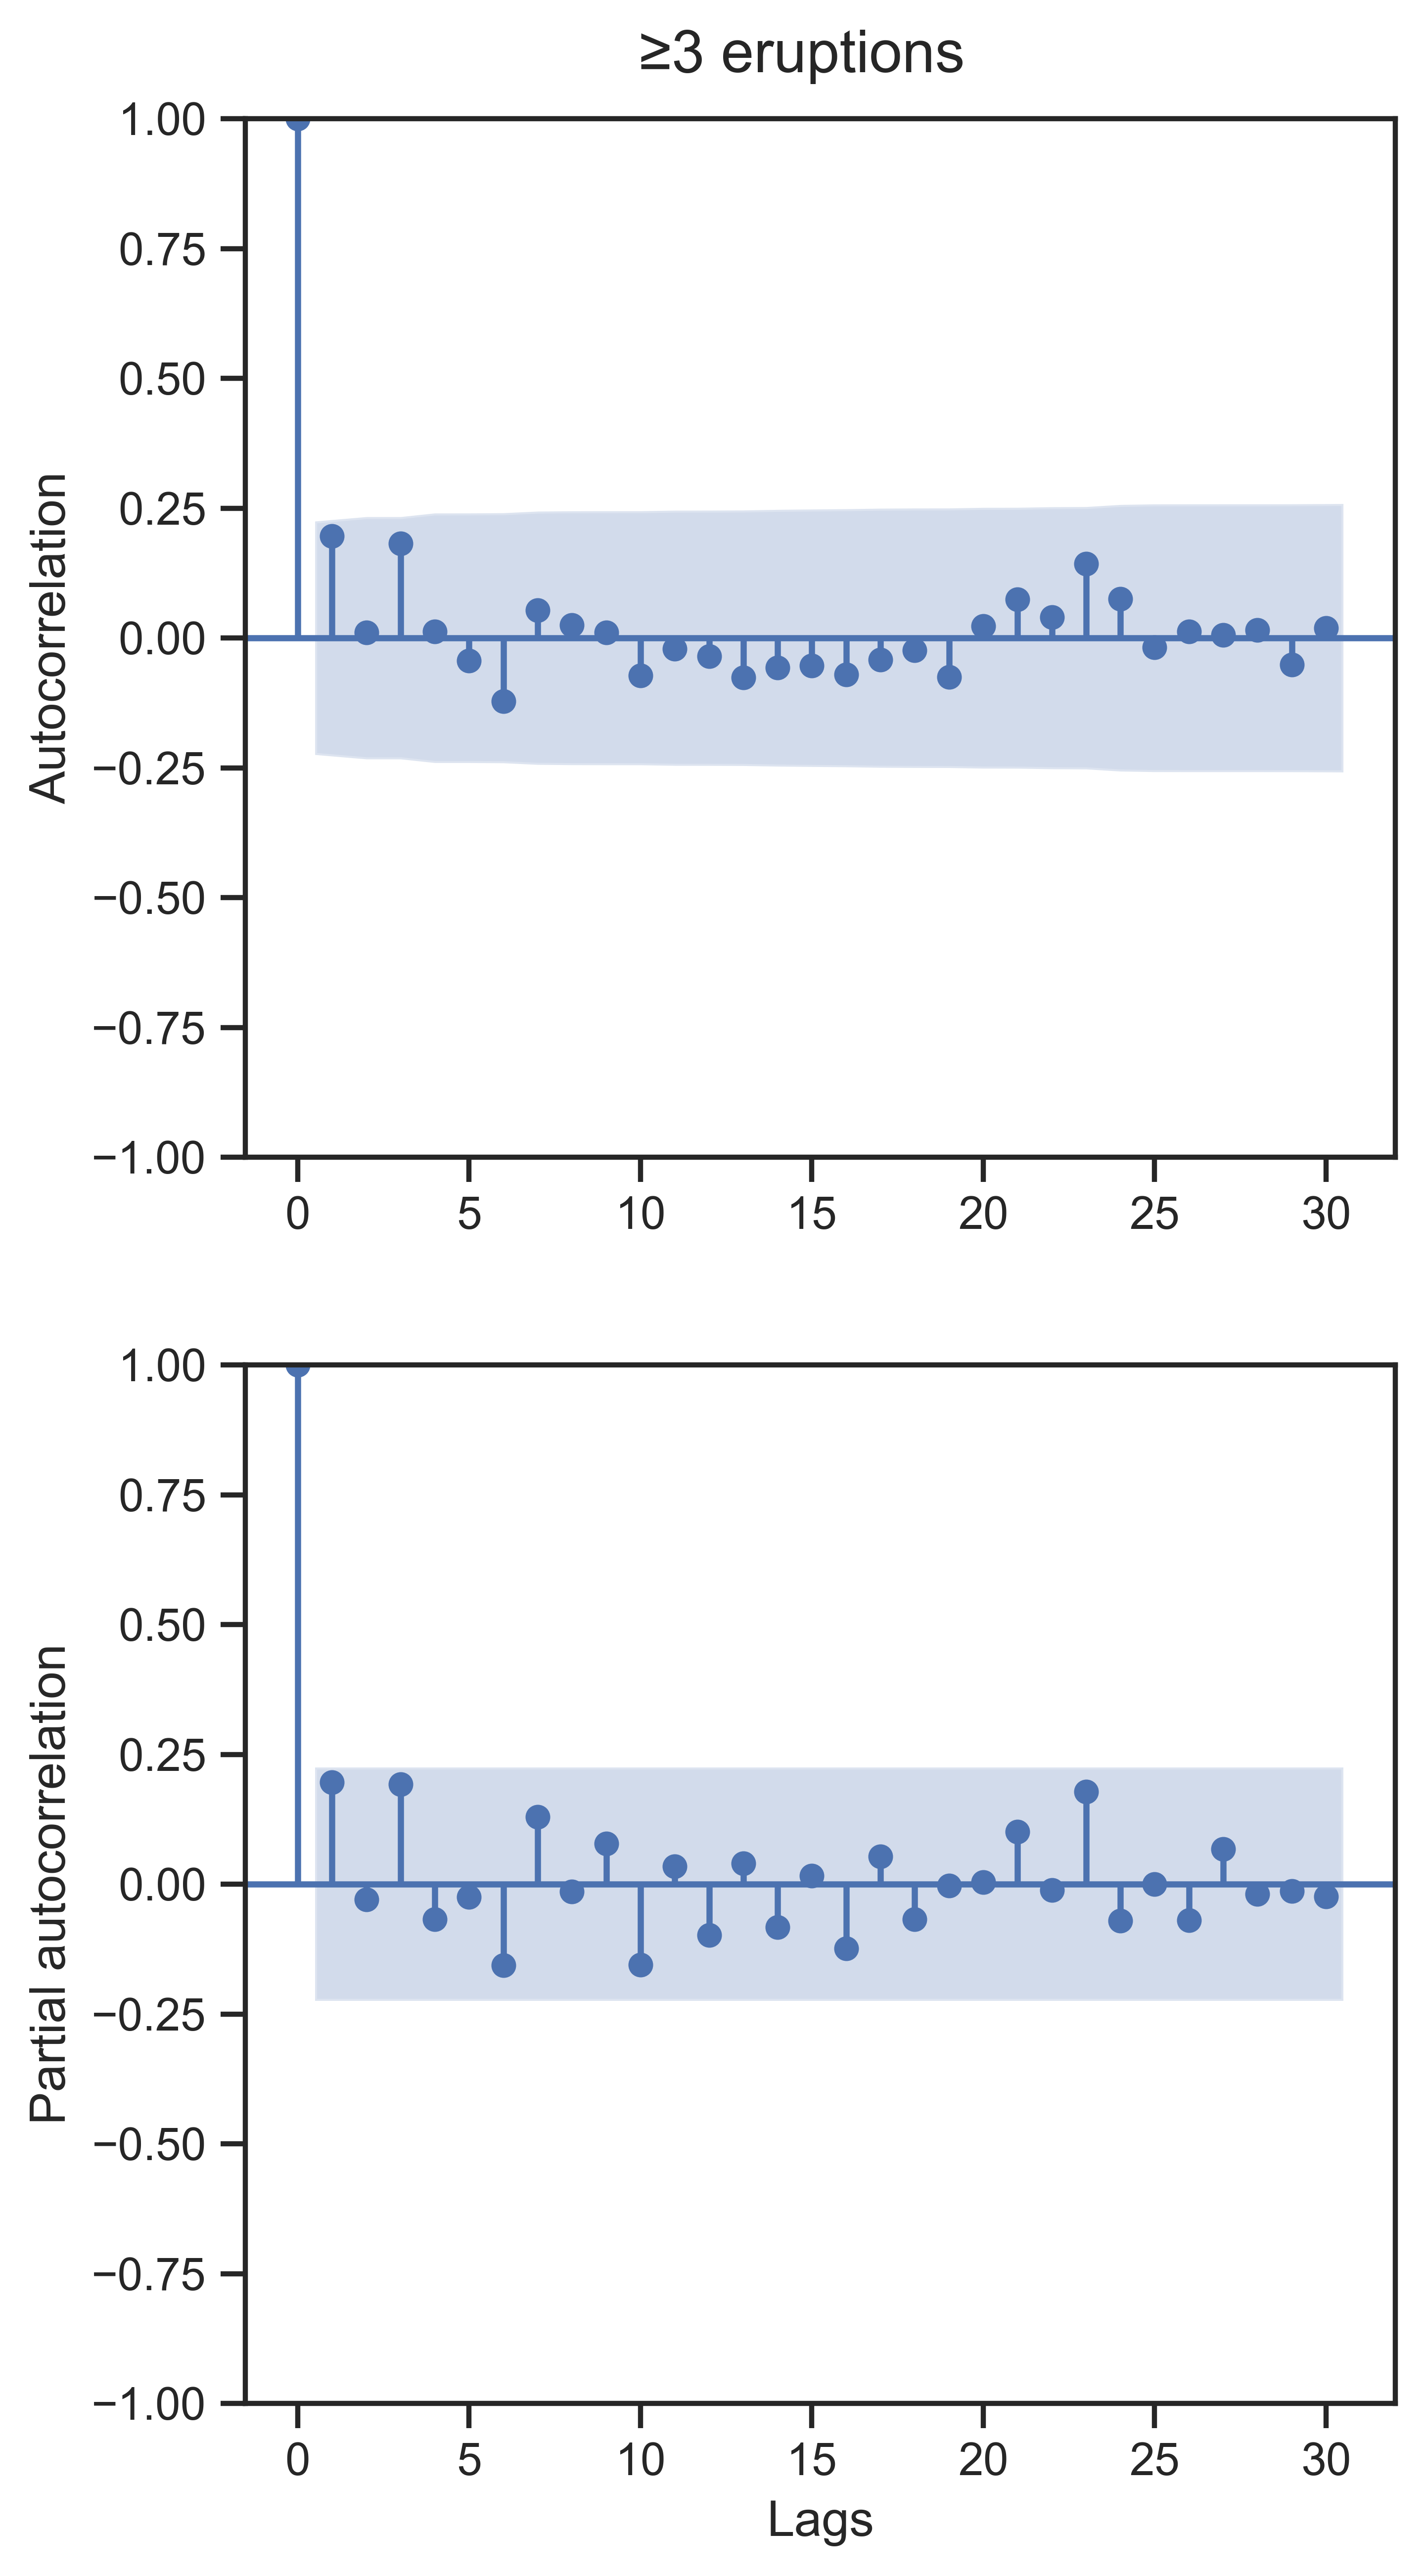

In [26]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))

# Check autocorrelation
plot_acf(x=list2['Repose'], lags=30, ax=axs[0])
fig.suptitle('≥3 eruptions',y=0.91)
axs[0].set_ylabel('Autocorrelation')
axs[0].set_title('')

# Check partial autocorrelation
plot_pacf(x=list2['Repose'], lags=30, ax=axs[1])
axs[1].set_ylabel('Partial autocorrelation')
axs[1].set_title('')
axs[1].set_xlabel('Lags')
plt.show()

## Descriptive statistic

In [22]:
print('modus :', list2['Repose'].mode())
print('median: ', list2['Repose'].median())
print('variansi: ', list2['Repose'].var())
print(list2['Repose'].describe())

modus : 0    1.0
Name: Repose, dtype: float64
median:  2.0
variansi:  11.173859649122809
count    76.000000
mean      2.697368
std       3.342732
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max      26.000000
Name: Repose, dtype: float64


## histogram repose time

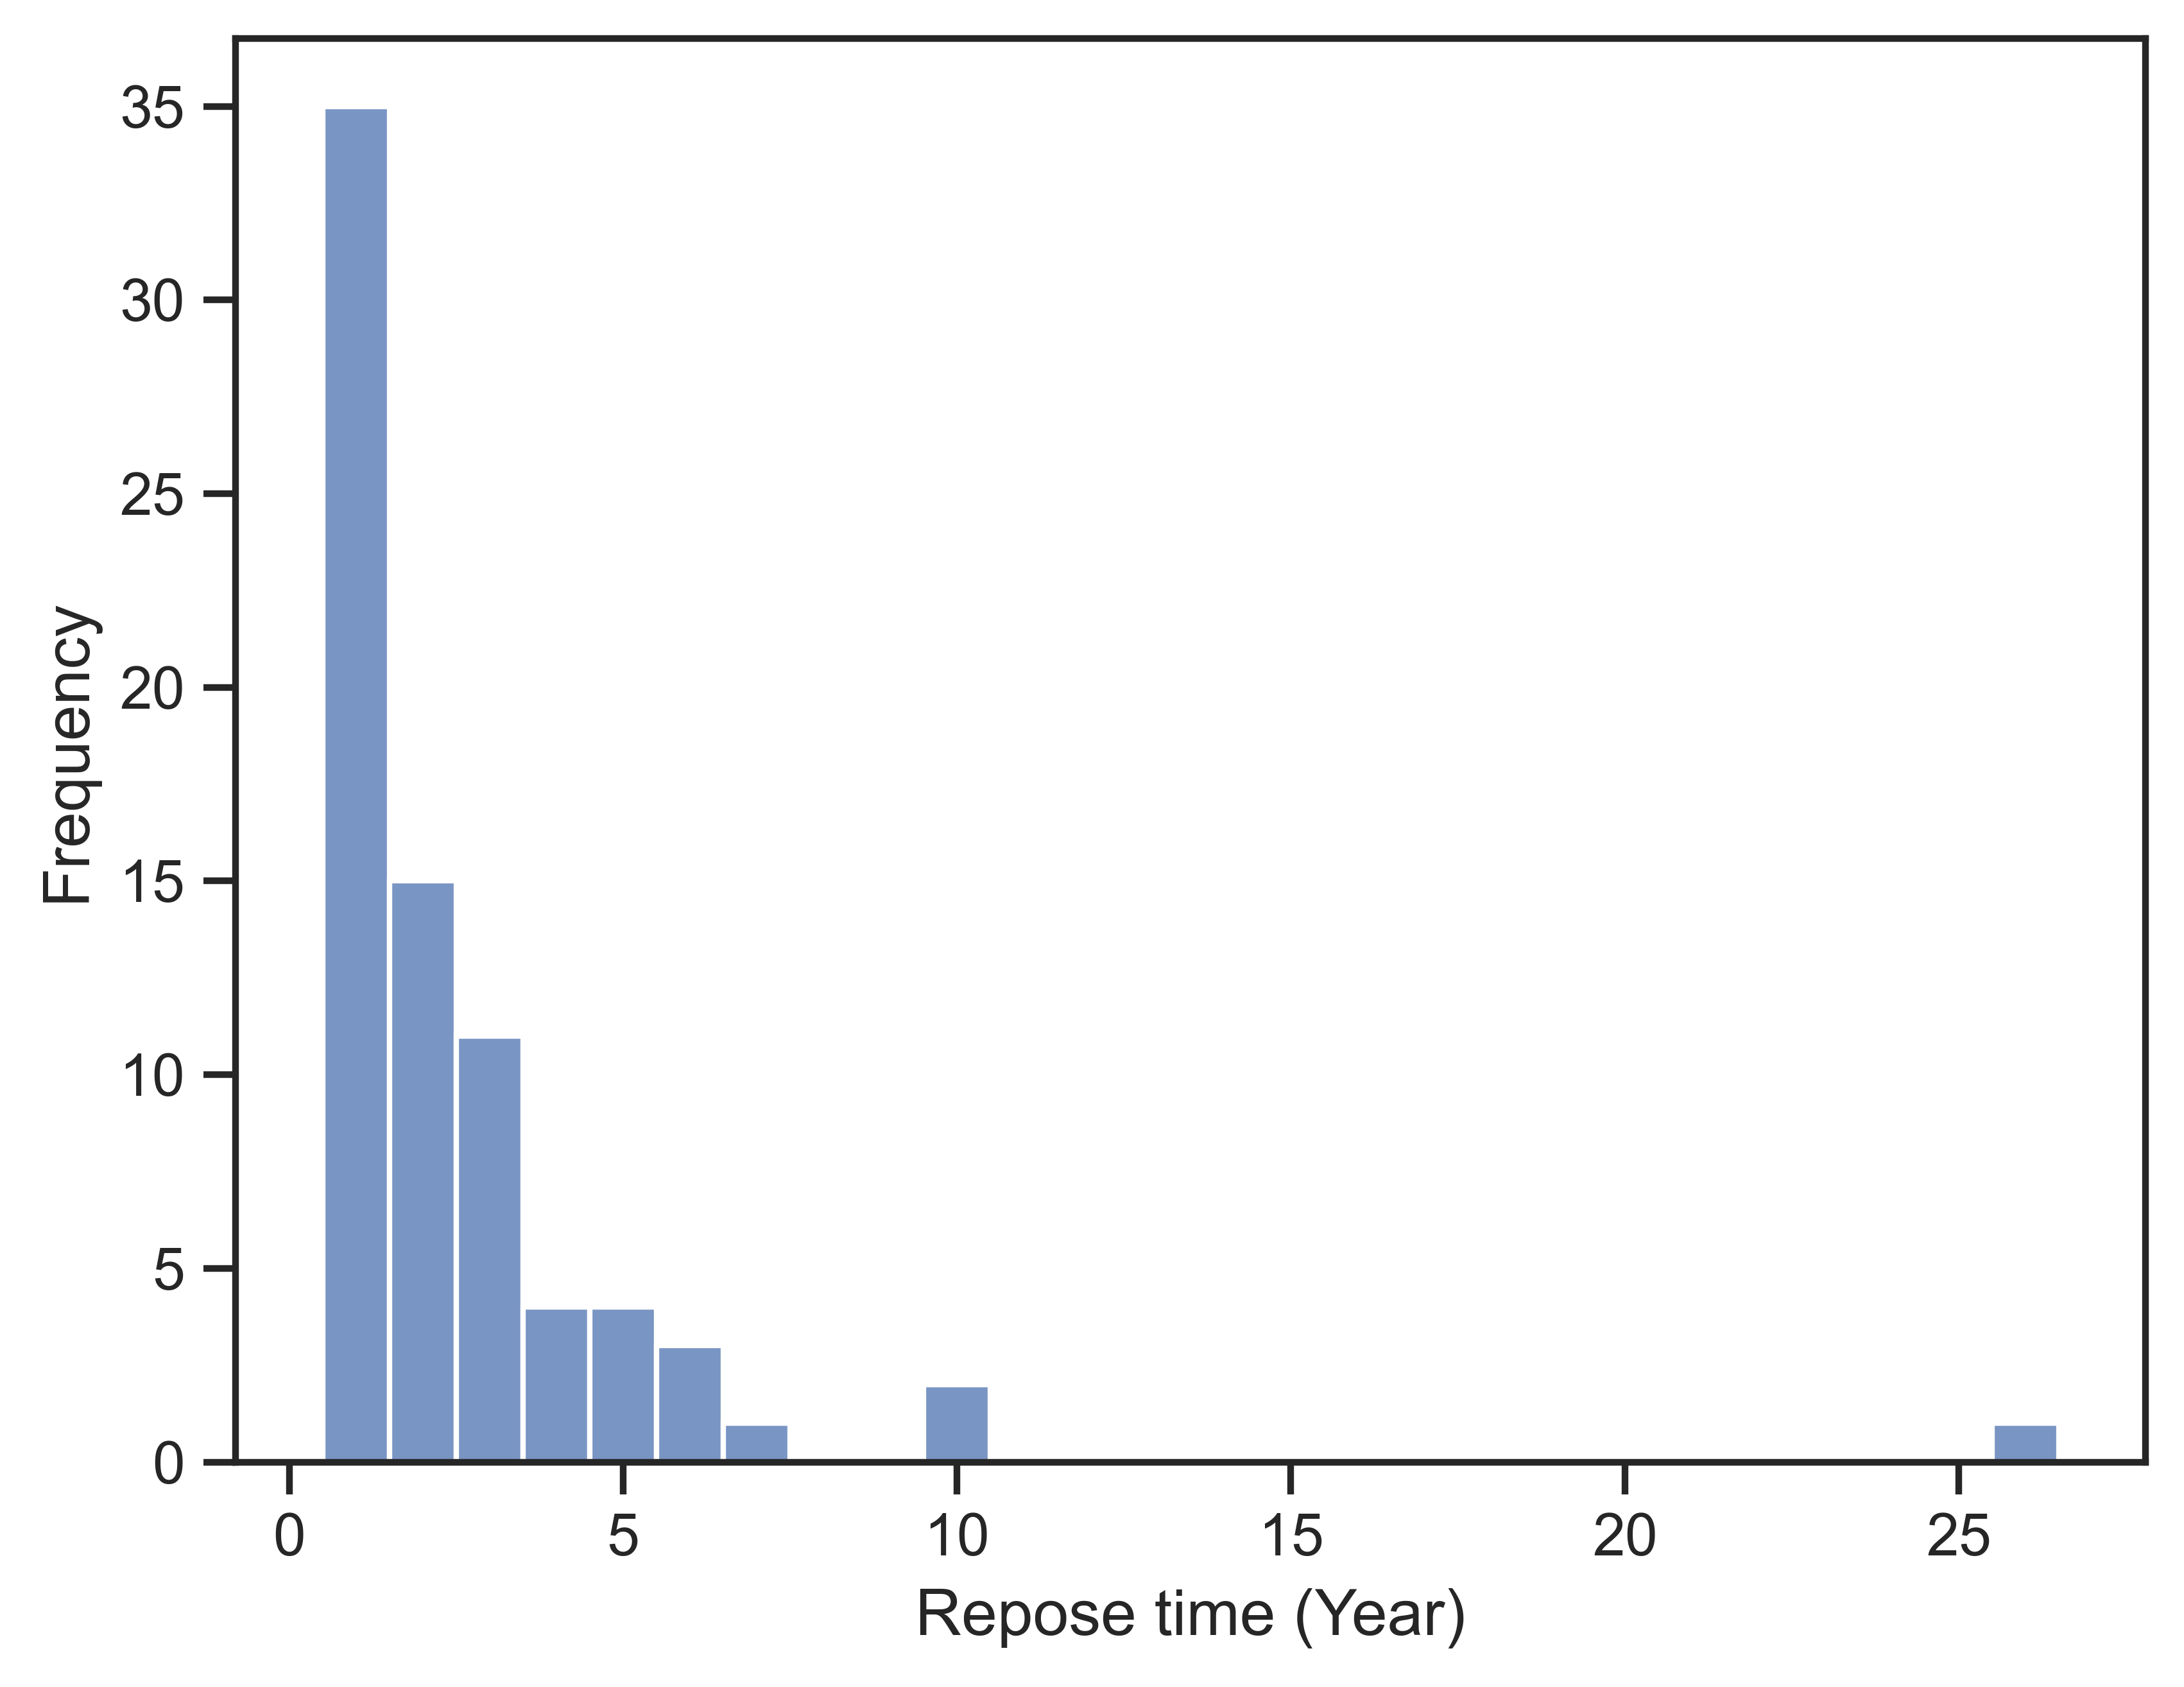

In [23]:
import seaborn as sns
sns.histplot(data=list2.Repose, discrete=True)
plt.ylabel('Frequency')
plt.xlabel('Repose time (Year)')
plt.show()

## Test

C:\Users\geika\AppData\Local\Temp\ipykernel_21188\577844916.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list2.loc[list2.Repose >=0, 'Status'] = 1
C:\Users\geika\AppData\Local\Temp\ipykernel_21188\577844916.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list2['Repose'] = list2['Repose'].replace([0], 0.5)


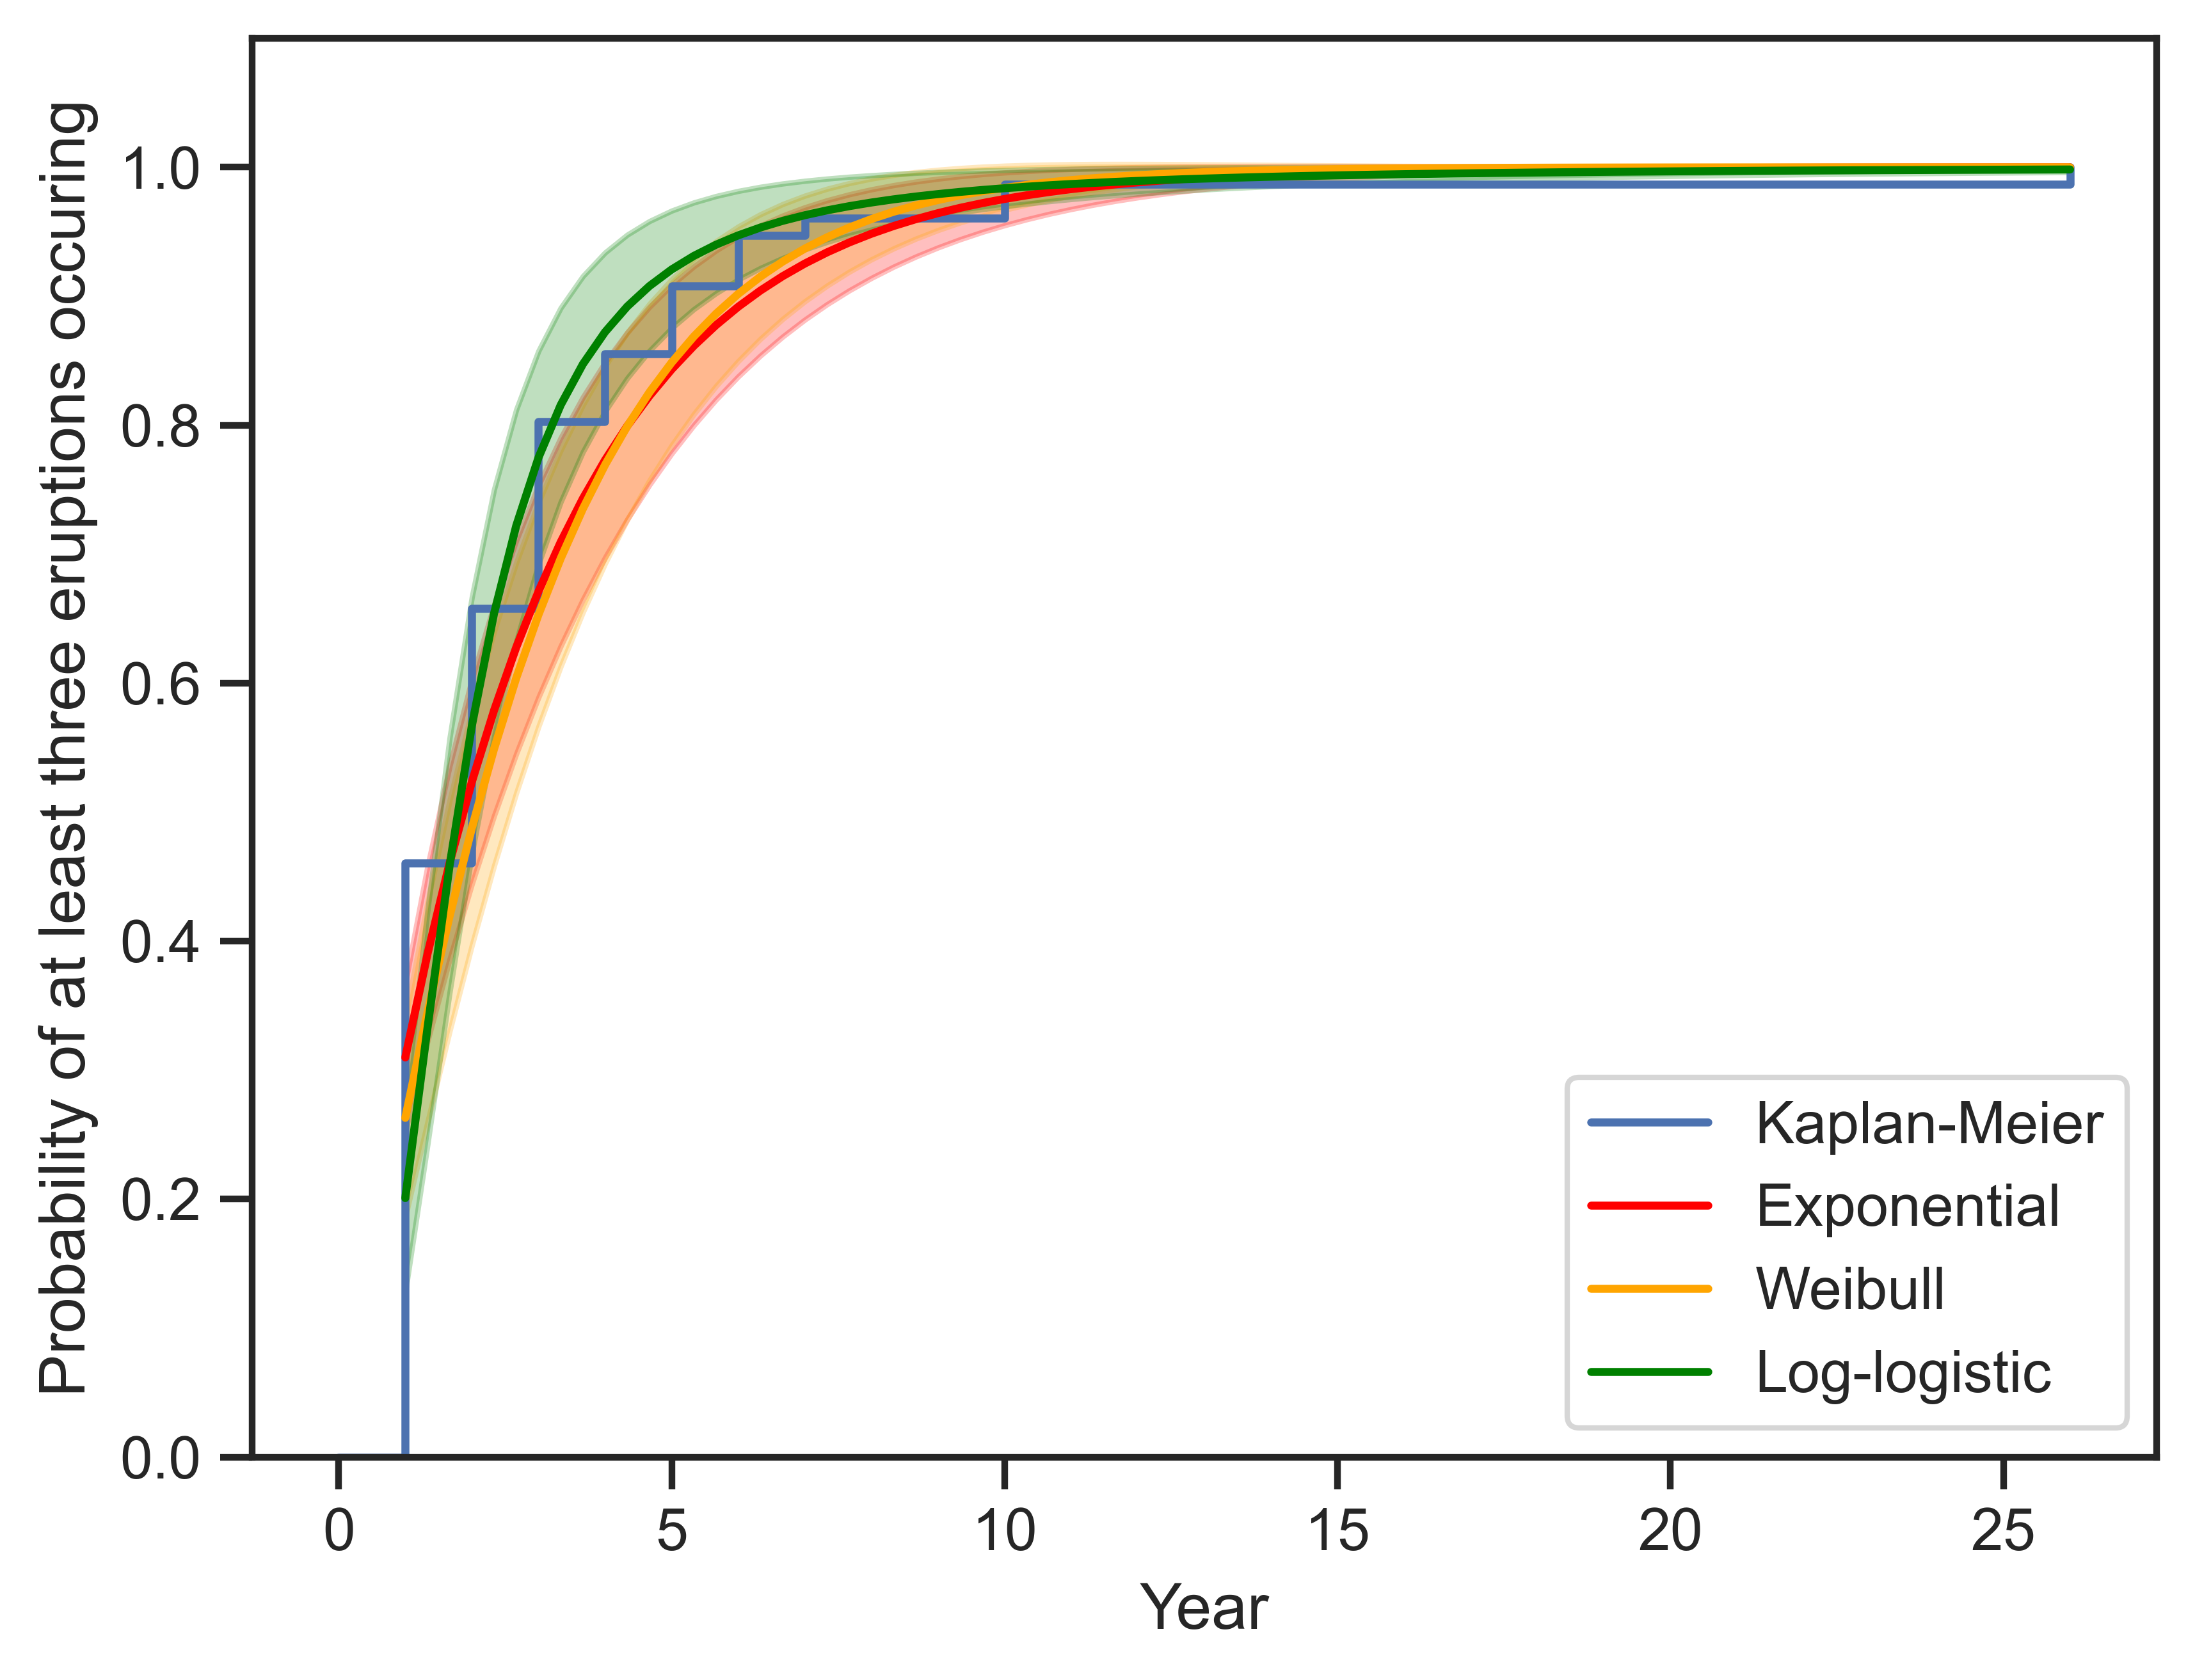

In [24]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
list2.loc[list2.Repose >=0, 'Status'] = 1
kmf.fit(durations=list2['Repose'], event_observed=list2['Status'], alpha=None)
list2['Repose'] = list2['Repose'].replace([0], 0.5)
kmf.plot_cumulative_density(ci_show=False, label='Kaplan-Meier')

#exponential
from lifelines import ExponentialFitter
exf = ExponentialFitter()
exf.fit(durations=list2['Repose'], event_observed=list2['Status'], alpha=None)
exf.plot_cumulative_density(ci_show=True, label='Exponential',color='red')

#weibull
from lifelines import WeibullFitter
wbf = WeibullFitter()
wbf.fit(durations=list2['Repose'], event_observed=list2['Status'], alpha=None)
wbf.plot_cumulative_density(ci_show=True, label='Weibull',color='orange')

#loglogistic
from lifelines import LogLogisticFitter
llf = LogLogisticFitter()
llf.fit(durations=list2['Repose'], event_observed=list2['Status'], alpha=None)
llf.plot_cumulative_density(ci_show=True, label='Log-logistic',color='green')
plt.ylabel('Probability of at least three eruptions occuring')
plt.xlabel('Year')

plt.ylim(0,1.1)
plt.yticks(np.arange(0,1.2,0.2))
plt.legend(loc=4)
plt.show()

## Evaluation

In [25]:
wbf.print_summary()
exf.print_summary()
llf.print_summary()

print(kmf.cumulative_density_at_times([0.5,1,2,3,4,5,6,7,8,9,10,15]))
print(wbf.cumulative_density_at_times([0.5,1,2,3,4,5,6,7,8,9,10,15]))
print(exf.cumulative_density_at_times([0.5,1,2,3,4,5,6,7,8,9,10,15]))
print(llf.cumulative_density_at_times([0.5,1,2,3,4,5,6,7,8,9,10,15]))

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 76 total observations, 0 right-censored observations>
   number of observations = 76
number of events observed = 76
           log-likelihood = -150.18
               hypothesis = lambda_ != 1, rho_ != 1

---
         coef  se(coef)  coef lower 95%  coef upper 95%
lambda_  2.85      0.31            2.25            3.46
rho_     1.13      0.09            0.96            1.30

         cmp to    z      p  -log2(p)
lambda_    1.00 6.02 <0.005     29.13
rho_       1.00 1.55   0.12      3.03
---
AIC = 304.37

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 76 total observations, 0 right-censored observations>
   number of observations = 76
number of events observed = 76
           log-likelihood = -151.41
               hypothesis = lambda_ != 0

---
         coef  se(coef)  coef lower 95%  coef upper 95%
lambda_  2.70      0.31            2.09            3.30

         cmp to    z      p  -log2(p)
lambda_    0.00 8.72 <0.005     58.29
---
AIC = 304.83

<lifelines.LogLogisticFitter:"LogLogistic_estimate", fitted with 76 total observations, 0 right-censored observations>
   number of observations = 76
number of events observed = 76
           log-likelihood = -134.21
               hypothesis = alpha_ != 1, beta_ != 1

---
        coef  se(coef)  coef lower 95%  coef upper 95%
alpha_  1.79      0.15            1.49            2.08
beta_   2.38      0.22            1.95            2.82

        cmp to    z      p  -log2(p)
alpha_    1.00 5.16 <0.005     21.92
beta_     1.00 6.21 <0.005     30.77
---
AIC = 272.42

0.5     0.000000
1.0     0.460526
2.0     0.657895
3.0     0.802632
4.0     0.855263
5.0     0.907895
6.0     0.947368
7.0     0.960526
8.0     0.960526
9.0     0.960526
10.0    0.986842
15.0    0.986842
Name: KM_estimate, dtype: float64
0.5     0.129918
1.0     0.262958
2.0     0.487739
3.0     0.653116
4.0     0.769277
5.0     0.848654
6.0     0.901847
7.0     0.936960
8.0     0.959854
9.0     0.974626
10.0    0.984071
15.0    0.998573
Name: Weibull_estimate, dtype: float64
0.5     0.169200
1.0     0.309771
2.0     0.523584
3.0     0.671164
4.0     0.773028
5.0     0.843337
6.0     0.891867
7.0     0.925363
8.0     0.948484
9.0     0.964442
10.0    0.975457
15.0    0.996155
Name: Exponential_estimate, dtype: float64
0.5     0.045960
1.0     0.200775
2.0     0.567095
3.0     0.774876
4.0     0.872303
5.0     0.920790
6.0     0.947226
7.0     0.962845
8.0     0.972693
9.0     0.979236
10.0    0.983771
15.0    0.993761
Name: LogLogistic_estimate, dtype: float64
